In [23]:
# Trying out something new
#tokens = " ".join(list(df["Text"]))
#tokens = re.findall(r'[A-Za-z]+|\d+|[^a-zA-Z0-9 ]+', tokens)

'''
###############################################################
--------------- Import of modules and libraries ---------------
###############################################################
'''

import pandas as pd
import numpy as np
import os, string, joblib
import matplotlib.pyplot as plt
from random import sample
from itertools import groupby

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Dense, LSTM, Embedding

In [25]:
inpath = os.path.join("data", "grimms_fairytales.csv")
LSTM_layers = [128, 100]
batchsize = 64
epochs = 350
ngenerated = 10

In [26]:
def generate_text_seq(model, tokenizer, sequence_length, seed_text, n_words):
  text = []

  for _ in range(n_words):
    encoded = tokenizer.texts_to_sequences([seed_text])[0]
    encoded = pad_sequences([encoded], maxlen = sequence_length, truncating='pre')

    y_predict = model.predict_classes(encoded)

    predicted_word = ''
    for word, index in tokenizer.word_index.items():
      if index == y_predict:
        predicted_word = word
        break
    seed_text = seed_text + ' ' + predicted_word
    text.append(predicted_word)
  return ' '.join(text)

In [27]:
'''
###############################################################
------------ Defining functions to be used in main ------------
###############################################################
'''
def text_processing(token_list):
    '''
    Function for processing a list of tokens. Removes punctuation and makes to lowercase.
    
    token_list: A list of tokens
    '''
    # Create a table for making a "translation" for all punctuations
    table = str.maketrans("", "", string.punctuation)
    
    # Apply the translation
    token_list = [token.translate(table) for token in token_list] # For token in tokens return the token after applying the translation using the table
    
    # Remove non-alphanumeric characters and convert to lowercase
    token_list = [token.lower() for token in token_list if token.isalpha()]

    # Return the processed token list
    return token_list

def get_sequences_running_window(token_list, window_size, window_step_length):
    '''
    Function for retrieving sequences of tokens in a list of tokens. Uses a moving window and saves a sequence for each window step.
            
    token_list: A list of tokens
    window_size: Size of the window -> determines the length of the sequences
    window_step_length: Step length of the window.     
    
    Example:
    Input: tokenlist = ["once", "upon", "a", "time", "in"], window_size = 3, window_step_length = 1
    Output: [["once upon a"], ["upon a time"], ["a time in"]]
    '''
    # Empty list for appending the sequences for each window
    sequences = []
    
    # For every number in a range of numbers
    # e.g. [window_size, window_size+1, window_size+3, window_size+3 ...] (up until) length of token list
    for i in range(window_size, len(token_list), window_step_length):
        
        # Define a sequence, which are tokens: i minus window_size to window_size. (e.g. [51-51: 51] -> [0:51])
        sequence = token_list[i-window_size:i]
        
        # Join this sequence of individual tokens to a single string:
        sequence = " ".join(sequence)
        
        # Append the sequence to list of sequences
        sequences.append(sequence)

    # Return the list of sequences
    return sequences

def vectorize_sequences(sequences):
    '''
    Function that vectorizes sequences. The vectors correspond to an ID that is saved in the tokenizer.
    
    sequences: A list of sequences. E.g. [["once upon a"], ["upon a time"], ["a time in"]]
    '''
    
    # Initialize tokenizer
    tokenizer = Tokenizer(filters = "")

    # Fit tokenizer to text (having every unique word assigned an integer for the model)
    tokenizer.fit_on_texts(sequences)

    # Have the sequences as integers (in a numpy array)
    sequences_int = np.array(tokenizer.texts_to_sequences(sequences))
    
    # Return sequences as vectors, and the tokenizer (to be able to convert from integers back to words again)
    return sequences_int, tokenizer

def model_init(vocabulary_length, sequence_length, LSTM_layers):
    '''
    Function that initializes the model used in the script
    
    vocabulary_length: Number of unique words in the texts
    sequence_length: Length of the sequences. Used as input shape for the model
    LSTM_layers: Number and size of LSTM_layers. E.g. [128, 128]
    '''
    
    # Initialize sequential
    model = Sequential()

    # Add embedding layer
    model.add(Embedding(vocabulary_length, # Input dimensions should be length of vocabulary
                        sequence_length, # Output dimensions should be length of each of the sequences
                        input_length = sequence_length)) # Input length, is also length of each of the sequences

    # Add LSTM layers
    for i in range(1, len(LSTM_layers)+1):
        
        # If the LSTM layer is not the last layer, then include "return_sequences = True" as input for the next layer
        if i < len(LSTM_layers):
            model.add(LSTM(LSTM_layers[i-1], 
                           return_sequences = True))
            
        # If the LSTM layer is the last, do not include return sequences.
        if i == len(LSTM_layers):
            model.add(LSTM(LSTM_layers[i-1]))        

    # Add dense layer
    model.add(Dense(32, 
                    activation = "relu"))

    # Add final dense layer
    model.add(Dense(vocabulary_length, # Output dimensions being the number of different options for predictions
                   activation = "softmax")) # Use softmax to get output predictions as probabilities

    # Define optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    # Compile model
    model.compile(loss = categorical_crossentropy, optimizer = optimizer, metrics = ["accuracy"])
    
    # Return the model
    return model

def plot_history(H, epoch, outpath):
    """
    Function which plots accuracy and loss over epochs (courtesy of Ross McLachlan)
    
    H: model history
    epoch: Number of epochs the model was trained with
    outpath: Outpath for saving the training history
    """
    # Visualizing performance
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, format='png', dpi=100)

def generate_sequences(model, tokenizer, sequence_length, seed_sequence, generated_sequence_length):
    '''
    Function that creates a new generated sequence using the predictions of a trained model.
    
    model: Model for which to use to generate sequences
    tokenizer: A fitted tokenizer for retrieving words from integers
    sequence_length: Length of the text sequences - to get correct format for the model
    seed_sequence: Starting word for the model to predict from
    generated_sequence_length: Specifies the wanted length of the generated sequence
    '''
    
    # Empty list for appending the individual tokens of the generated text
    generated_text = []
    
    # Go through below loop, until the wanted generated sequence length has been met
    for _ in range(generated_sequence_length):
        
        # Encode the seed text as an integer - with the integer matching the index in the trained tokenizer
        encoded = tokenizer.texts_to_sequences([seed_sequence])[0]
        
        # Pad the encoding to reach length of the input format of the model
        encoded = pad_sequences([encoded], maxlen = sequence_length, truncating = "pre")
        
        # Using the encoded seed sequence that has been padded, predict the most likely next word
        y_predicted = model.predict_classes(encoded)
        
        # Initialize empty string (required to make the next loop work)
        predicted_word = ""
        
        # For each word, and its index (ID) in the dictionary of words and their ID from the trained tokenizer,
        for word, index, in tokenizer.word_index.items():
            
            # If the index of the newly predicted word matches, assign the word string to "predicted_word"
            if index == y_predicted:
                predicted_word = word
                break
            
        # The seed_sequence should then have added the newly predicted word, with a space in between the words for next runthrough of loop
        seed_sequence = seed_sequence + " " + predicted_word
            
        # The generated string tokens should then be appended to the empty list
        generated_text.append(predicted_word)

    # Join together the tokens in the generated text, to have one coherent string
    generated_string = " ".join(generated_text)
    
    # Return generated string
    return generated_string

def generate_sequences_multiple(model, ngenerated, length, tokenizer, seed_sequences):
    '''
    Function which utilizes the generate_sequences function to generate multiple sequences of a given length using a with a random seed sequence
    
    model: Trained model used to generate new tokens
    ngenerated: Number of new sequences that is wanted to be generated
    length: Desired length of new sequences
    tokenizer: Fitted tokenizer with token ID's
    seed_sequences: A list of sequences that may be used as seeds
    '''
    
    # Empty list of generated strings for appending to
    generated_strings = []

    # Create ngenerated (an integer) generated sequences of text
    for _ in range(0, ngenerated):

        # Take a single random sample from the possible seed sequences and join the tokens to one string
        seed_sequence = " ".join(sample(seed_sequences, 1))

        # Generate a new string, using the seed_sequence as input
        generated_string = generate_sequences(model = model,
                                          tokenizer = tokenizer,
                                          sequence_length = len(seed_sequence),
                                          seed_sequence = seed_sequence,
                                          generated_sequence_length = length)

        # Add newly generated string to list of generated strings
        generated_strings.append(generated_string)
        
    # Return generated_strings
    return generated_strings

In [28]:
# Load in the dataset
df = pd.read_csv(inpath)

# Create a list of all the texts in the corpus and split it into individual tokens
text = ' '.join(list(df["Text"])).split()

# Process the text and return the list of processed tokens.
tokens = text_processing(text)

# Get sequences using a running window.
# E.g. going from ["once upon a time in hollywood"] to ["once upon a", "upon a time", "a time in", "time in hollywood"]
sequences = get_sequences_running_window(tokens, 51, 1)

# Initialize tokenizer
tokenizer = Tokenizer()

# Fit tokenizer to text (having every unique word assigned an integer for the model)
tokenizer.fit_on_texts(sequences)

# Have the sequences as integers (in a numpy array)
sequences_int = np.array(tokenizer.texts_to_sequences(sequences))

# Vectorize the sequences
sequences_int, tokenizer = vectorize_sequences(sequences)

# Assign X (our training variable) all the tokens in each the sequences, except for the last token in the sequence
X = sequences_int[:, :-1]

# Assign y (our testing varible) the last token in each of the sequences
y = sequences_int[:, -1]

# Define how many unique words we're dealing with
vocabulary_length = len(set(tokens)) + 1 # +1 for the reserved index

# Define the length of the training sequences
sequence_length = X.shape[1]

# Convert y to one-hot encoding instead of integer.
y = to_categorical(y, num_classes = vocabulary_length)

# Initiate model
model = model_init(vocabulary_length, sequence_length, LSTM_layers)

In [29]:
# Fit the model to the data
history = model.fit(X, y, batch_size = batchsize, epochs = epochs)

Epoch 1/350
1495/1495 [==============================] - 159s 104ms/step - loss: 6.3229 - accuracy: 0.0678
Epoch 2/350
1495/1495 [==============================] - 152s 101ms/step - loss: 5.6892 - accuracy: 0.0866
Epoch 3/350
1495/1495 [==============================] - 152s 101ms/step - loss: 5.4595 - accuracy: 0.1025
Epoch 4/350
1495/1495 [==============================] - 154s 103ms/step - loss: 5.2544 - accuracy: 0.1264
Epoch 5/350
1495/1495 [==============================] - 152s 102ms/step - loss: 5.0961 - accuracy: 0.1339
Epoch 6/350
1495/1495 [==============================] - 152s 102ms/step - loss: 4.9626 - accuracy: 0.1428
Epoch 7/350
1495/1495 [==============================] - 150s 100ms/step - loss: 4.8613 - accuracy: 0.1477
Epoch 8/350
1495/1495 [==============================] - 147s 99ms/step - loss: 4.7763 - accuracy: 0.1515
Epoch 9/350
1495/1495 [==============================] - 151s 101ms/step - loss: 4.7065 - accuracy: 0.1544
Epoch 10/350
1495/1495 [==============

1495/1495 [==============================] - 148s 99ms/step - loss: 2.9273 - accuracy: 0.3414
Epoch 78/350
1495/1495 [==============================] - 148s 99ms/step - loss: 2.9074 - accuracy: 0.3419
Epoch 79/350
1495/1495 [==============================] - 146s 98ms/step - loss: 2.8832 - accuracy: 0.3443
Epoch 80/350
1495/1495 [==============================] - 146s 98ms/step - loss: 2.8581 - accuracy: 0.3536
Epoch 81/350
1495/1495 [==============================] - 148s 99ms/step - loss: 2.8388 - accuracy: 0.3553
Epoch 82/350
1495/1495 [==============================] - 147s 98ms/step - loss: 2.8116 - accuracy: 0.3586
Epoch 83/350
1495/1495 [==============================] - 146s 98ms/step - loss: 2.8073 - accuracy: 0.3617
Epoch 84/350
1495/1495 [==============================] - 147s 98ms/step - loss: 2.7678 - accuracy: 0.3692
Epoch 85/350
1495/1495 [==============================] - 146s 98ms/step - loss: 2.7541 - accuracy: 0.3713
Epoch 86/350
1495/1495 [==========================

1495/1495 [==============================] - 150s 100ms/step - loss: 1.8807 - accuracy: 0.5315
Epoch 153/350
1495/1495 [==============================] - 152s 102ms/step - loss: 1.8797 - accuracy: 0.5305
Epoch 154/350
1495/1495 [==============================] - 151s 101ms/step - loss: 1.8749 - accuracy: 0.5326
Epoch 155/350
1495/1495 [==============================] - 152s 102ms/step - loss: 1.9086 - accuracy: 0.5248
Epoch 156/350
1495/1495 [==============================] - 149s 100ms/step - loss: 1.8478 - accuracy: 0.5365
Epoch 157/350
1495/1495 [==============================] - 151s 101ms/step - loss: 1.8514 - accuracy: 0.5377
Epoch 158/350
1495/1495 [==============================] - 148s 99ms/step - loss: 1.8433 - accuracy: 0.5403
Epoch 159/350
1495/1495 [==============================] - 150s 100ms/step - loss: 1.8159 - accuracy: 0.5473
Epoch 160/350
1495/1495 [==============================] - 150s 101ms/step - loss: 1.9011 - accuracy: 0.5268
Epoch 161/350
1495/1495 [=========

1495/1495 [==============================] - 152s 101ms/step - loss: 1.5174 - accuracy: 0.6070
Epoch 228/350
1495/1495 [==============================] - 152s 102ms/step - loss: 1.5016 - accuracy: 0.6112
Epoch 229/350
1495/1495 [==============================] - 147s 98ms/step - loss: 1.5093 - accuracy: 0.6097
Epoch 230/350
1495/1495 [==============================] - 149s 100ms/step - loss: 1.5157 - accuracy: 0.6068
Epoch 231/350
1495/1495 [==============================] - 147s 98ms/step - loss: 1.4768 - accuracy: 0.6168
Epoch 232/350
1495/1495 [==============================] - 149s 100ms/step - loss: 1.4885 - accuracy: 0.6163
Epoch 233/350
1495/1495 [==============================] - 150s 100ms/step - loss: 1.5062 - accuracy: 0.6082
Epoch 234/350
1495/1495 [==============================] - 151s 101ms/step - loss: 1.4680 - accuracy: 0.6171
Epoch 235/350
1495/1495 [==============================] - 148s 99ms/step - loss: 1.4798 - accuracy: 0.6150
Epoch 236/350
1495/1495 [===========

1495/1495 [==============================] - 159s 106ms/step - loss: 1.3523 - accuracy: 0.6404
Epoch 303/350
1495/1495 [==============================] - 162s 108ms/step - loss: 1.3530 - accuracy: 0.6414
Epoch 304/350
1495/1495 [==============================] - 163s 109ms/step - loss: 1.3353 - accuracy: 0.6460
Epoch 305/350
1495/1495 [==============================] - 160s 107ms/step - loss: 1.3165 - accuracy: 0.6544
Epoch 306/350
1495/1495 [==============================] - 162s 108ms/step - loss: 1.3328 - accuracy: 0.6456
Epoch 307/350
1495/1495 [==============================] - 162s 108ms/step - loss: 1.3724 - accuracy: 0.6377
Epoch 308/350
1495/1495 [==============================] - 180s 120ms/step - loss: 1.3191 - accuracy: 0.6514
Epoch 309/350
1495/1495 [==============================] - 179s 120ms/step - loss: 1.3693 - accuracy: 0.6369
Epoch 310/350
1495/1495 [==============================] - 157s 105ms/step - loss: 1.2975 - accuracy: 0.6557
Epoch 311/350
1495/1495 [========

In [31]:
# Saving the trained model
outpath_cnn_model = os.path.join("out", "cnn_model.pkl")
joblib.dump(model, outpath_cnn_model)
print(f"[INFO] The trained CNN model has been saved: \"{outpath_cnn_model}\".")

TypeError: can't pickle weakref objects

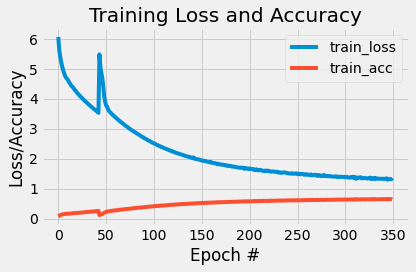

In [32]:
outpath_training_hist = os.path.join("out", "training_hist.png")
plot_history(history, epochs, outpath_training_hist)

In [ ]:
'''
###############################################################
---------- Defining the main function of the script -----------
###############################################################
'''

In [33]:
generate_text_seq(model, tokenizer, sequence_length, sequences[2], 20)

/home/cds-au604547/cds-language-exam/lang101/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'the enchantress a whit the leathern they had and snowdrop went to the son he equipped from long the bear'

In [34]:
generate_sequences(model, tokenizer, sequence_length, sequences[2189], 20)

'fox came to the sea some beasts and said to himself i will let it choose safe hazeltree where the'

In [43]:
generated_sequences_10 = generate_sequences_multiple(model, 50, 10, tokenizer, sequences)

In [44]:
generated_sequences_30 = generate_sequences_multiple(model, 50, 30, tokenizer, sequences)

In [45]:
generated_sequences_50 = generate_sequences_multiple(model, 50, 50, tokenizer, sequences)

In [46]:
generated_sequences_100 = generate_sequences_multiple(model, 50, 100, tokenizer, sequences)

In [48]:
df = pd.DataFrame.from_dict({"length_10" : generated_sequences_10,
                             "length_30" : generated_sequences_30,
                             "length_50" : generated_sequences_30,
                             "length_100" : generated_sequences_30})

In [49]:
# Define outpath and save dataframe
if not os.path.exists("out"): # If the folder does not already exist, create it
    os.makedirs("out")

In [50]:
outpath = os.path.join("out", "generated_strings.csv")
df.to_csv(outpath)

In [51]:
df.head()

,length_10,length_30,length_50,length_100
0,from whence his wealth came to see them to the,soon as he had heard a wishingcloak was a loud...,soon as he had heard a wishingcloak was a loud...,soon as he had heard a wishingcloak was a loud...
1,cried is himself give me my head then the king,fast clack light upon a little of his four bro...,fast clack light upon a little of his four bro...,fast clack light upon a little of his four bro...
2,kitchen and shook out the willowwren flew up t...,i shall not be of and as if i have you said he...,i shall not be of and as if i have you said he...,i shall not be of and as if i have you said he...
3,foot and limped hobblety jib hobblety and when...,her hundred different long years in the frogs ...,her hundred different long years in the frogs ...,her hundred different long years in the frogs ...
4,and when he had gone on her she walked out,here but chanticleer began into his pocket the...,here but chanticleer began into his pocket the...,here but chanticleer began into his pocket the...
